# Korrelationen Zipf-Luhn zu publish_date

In [173]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [190]:
# Aktienkursdaten laden
stock_prices = pd.read_csv('../../stock_price/stocks.csv')
stock_prices['Date'] = pd.to_datetime(stock_prices['Date']).dt.date
stock_prices['Close'] = stock_prices['Close'].replace('[\$,]', '', regex=True).astype(float)
stock_prices['Open'] = stock_prices['Open'].replace('[\$,]', '', regex=True).astype(float)
stock_prices['High'] = stock_prices['High'].replace('[\$,]', '', regex=True).astype(float)
stock_prices['Low'] = stock_prices['Low'].replace('[\$,]', '', regex=True).astype(float)
stock_prices['Volume'] = stock_prices['Volume'].astype(int)
stock_prices.set_index('Date', inplace=True)
stock_prices.sort_index(inplace=True)
stock_prices.head(200)

,Close,Volume,Open,High,Low
Date,,,,,
2014-04-23,130.63,7116903,130.67,131.50,129.33
2014-04-24,129.86,4176995,130.41,130.62,128.43
2014-04-25,128.66,2978517,129.84,130.00,128.37
2014-04-28,127.04,4350384,128.20,128.87,125.80
2014-04-29,128.37,3343764,127.20,128.57,126.53
...,...,...,...,...,...
2015-01-30,145.37,11264180,146.22,146.85,144.37
2015-02-02,146.26,6790894,143.72,146.59,143.05
2015-02-03,147.34,5978090,146.37,148.00,146.18


In [175]:
def print_progress(current, total):
    progress_length = 50
    percent_complete = current / total
    bars = int(progress_length * percent_complete)
    progress_bar = '#' * bars + '-' * (progress_length - bars)
    print(f"\r[{progress_bar}] {int(100 * percent_complete)}% - Artikel {current} von {total}", end="")
    

In [176]:
# Verbindungsinformationen für die MongoDB
username = 'admin'
password = 'admin'
host = 'localhost'
port = '27017'
authSource = 'admin'

# Verbindung zur MongoDB
client = MongoClient(f'mongodb://{username}:{password}@{host}:{port}/?authSource={authSource}')
db = client.web_articles
articles_collection = db.articles

# Artikel aus MongoDB extrahieren
articles = list(articles_collection.find({}, {'publish_date': 1, 'zipf_luhn_keywords': 1, 'article_publisher': 1, 'preprocessed_text': 1}))

In [177]:
def get_stock_price(date, stock_prices):
    
    # Sicherstellen, dass das 'date'-Argument ein datetime-Objekt ist
    #date = pd.to_datetime(date)

    # Finde den letzten verfügbaren Kurs vor dem Datum
    before = stock_prices[stock_prices.index < date]
    if not before.empty:
        closest_before_c = before.iloc[-1]['Close']
        closest_before_v = before.iloc[-1]['Volume']
    else:
        closest_before_c = None
        closest_before_v = None
    
    # Finde den ersten verfügbaren Kurs nach dem Datum
    after = stock_prices[stock_prices.index > date]
    if not after.empty:
        closest_after_c = after.iloc[0]['Close']
        closest_after_v = after.iloc[0]['Volume']
    else:
        closest_after_c = None
        closest_after_v = None

    # Überprüfe, ob ein Preis am gegebenen Datum direkt im DataFrame vorhanden ist
    # Das "in" Keyword prüft hier auf Übereinstimmung im Index
    if date in stock_prices.index:
        # .loc wird verwendet, um Zeilen anhand von Label/Index zu holen
        return [stock_prices.loc[date, 'Close'], closest_after_c, stock_prices.loc[date, 'Volume'], closest_after_v]

    return [closest_before_c, closest_after_c, closest_before_v, closest_after_v]




In [194]:
# DataFrame erstellen
articles_df = pd.DataFrame(articles)
articles_df['publish_date'] = pd.to_datetime(articles_df['publish_date'],errors='coerce')
articles_df.dropna(inplace=True)
articles_df.set_index('publish_date', inplace=True)
articles_df.sort_index(inplace=True)


# Aktienkurs für jedes Datum abrufen
articles_df['stock_price_publish'] = articles_df.index.map(lambda x: get_stock_price(x.date(), stock_prices)[0])
# Aktienkurs für jedes Datum abrufen
articles_df['stock_price_after_publish'] = articles_df.index.map(lambda x: get_stock_price(x.date(), stock_prices)[1])

# Aktienkurs für jedes Datum abrufen
articles_df['stock_volume_publish'] = articles_df.index.map(lambda x: get_stock_price(x.date(), stock_prices)[2])
# Aktienkurs für jedes Datum abrufen
articles_df['stock_volume_after_publish'] = articles_df.index.map(lambda x: get_stock_price(x.date(), stock_prices)[3])

# Anzahl der Schlüsselwörter berechnen
articles_df['keyword_count'] = articles_df['zipf_luhn_keywords'].apply(len)
articles_df['textword_count'] = articles_df['preprocessed_text'].apply(len)
placeholder = articles_df


# Setzen des Seeds für Reproduzierbarkeit
n = np.random.seed(42)

articles_df = articles_df.sample(n=100)
articles_df.dropna(inplace=True)
articles_df.sort_index(inplace=True)
articles_df.head(10)

,_id,article_publisher,preprocessed_text,zipf_luhn_keywords,stock_price_publish,stock_price_after_publish,stock_volume_publish,stock_volume_after_publish,keyword_count,textword_count
publish_date,,,,,,,,,,
2014-05-19 12:00:41+00:00,6617dfd81435cf17d7da26be,CNBC,stock index future trade lower monday follow w...,"[fed, speak, mtg, earning, alstom, bid, willia...",131.35,129.58,2103063.0,2995763.0,100,2142
2014-08-20 23:46:52+00:00,6617dfd81435cf17d7da2659,CNBC,india big company pour billion dollar manufact...,"[india, defense, modi, larsen, mahindra, tata,...",127.35,127.50,4316599.0,2522227.0,100,3614
2014-10-13 12:59:22+00:00,6617dfd81435cf17d7da2629,CNBC,australian prime minister tony abbott vow shir...,"[mr, putin, abbott, australian, rebel, russian...",120.45,122.29,3874221.0,3768107.0,100,2161
2014-11-14 18:39:10+00:00,6617dfd81435cf17d7da260e,CNBC,year pop high profile event sport google glass...,"[glass, google, developer, brin, app, consumer...",128.86,128.42,6231178.0,3752879.0,100,4377
2015-04-25 11:13:00+00:00,6617dfd81435cf17d7da0a76,Nasdaq,warthogs fly photo wikimedia commons general w...,"[warthog, force, air, ultimately, fact, cannon...",148.40,147.80,4888930.0,4599289.0,100,3584
2015-05-10 04:07:00+00:00,6617dfd81435cf17d7da0a72,Nasdaq,uss donald cook lead flotilla destroyer photo ...,"[aegis, bmd, missile, destroyer, uss, ddg, rus...",145.46,145.89,7067583.0,3963424.0,100,3985
2015-06-23 14:53:00+00:00,6617dfd81435cf17d7da0a63,Nasdaq,boeing ba report board director today declare ...,"[july, dividend, payable, declare, wdfc, commo...",144.43,143.00,2852681.0,3982116.0,57,860
2015-10-13 13:21:32+00:00,6617dfd81435cf17d7da2538,CNBC,malaysia airlines flight down russian warhead ...,"[dutch, ukraine, buk, warhead, rebel, conflict...",140.29,134.22,2337048.0,8746081.0,100,1841
2015-11-25 13:30:00+00:00,6617dfd81435cf17d7da2510,CNBC,gauge business investment plan surge october l...,"[percent, spending, order, september, upwardly...",147.43,146.95,1852242.0,1282131.0,100,1541


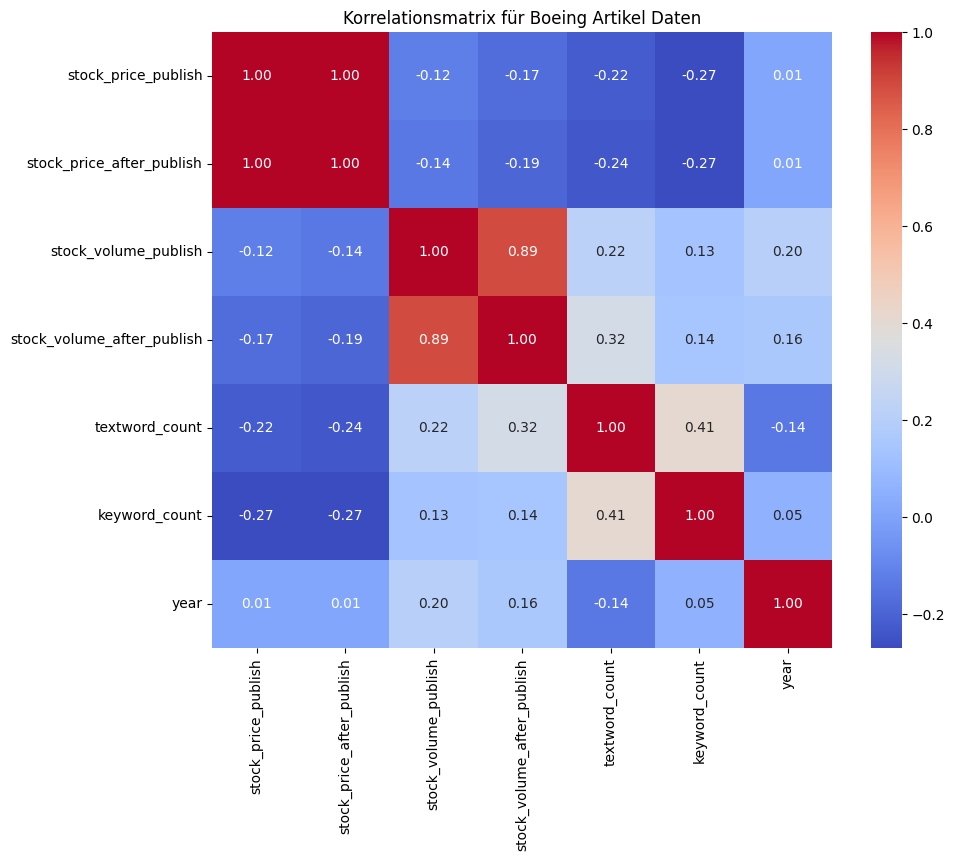

In [198]:
df = articles_df
df['publish_date'] = pd.to_datetime(df.index)

# Umwandlung in numerische Daten für Korrelation
df['year'] = df['publish_date'].dt.year

# Berechnung der Korrelationsmatrix
correlation_matrix = df[['stock_price_publish', 'stock_price_after_publish', 'stock_volume_publish', 'stock_volume_after_publish', 'textword_count', 'keyword_count', 'year']].corr()

# Visualisierung der Korrelationsmatrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelationsmatrix für Boeing Artikel Daten')
plt.show()
